In [2]:
%matplotlib inline

from __future__ import print_function, absolute_import

import os
import argparse
import time
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torchvision.datasets as datasets

from pose import Bar
from pose.utils.logger import Logger, savefig
from pose.utils.evaluation import accuracy, AverageMeter, final_preds
from pose.utils.misc import save_checkpoint, save_pred, adjust_learning_rate
from pose.utils.osutils import mkdir_p, isfile, isdir, join
from pose.utils.imutils import batch_with_heatmap
from pose.utils.transforms import fliplr, flip_back
import pose.models as models
import pose.datasets as datasets

os.environ['CUDA_VISIBLE_DEVICES']='3'


In [4]:
# parameters
arch = 'hg'
stacks = 1
blocks = 1
classes = 16
weights_path = '/home/ubuntu/cvlab/meego/pytorch-pose/pretrained_weights/hg_s1_b1/model_best.pth.tar'

# construct the base Stacked Hourglass Nets model
stacked_hourglass_nets = models.__dict__[arch](num_stacks=stacks, num_blocks=blocks, num_classes=classes)
stacked_hourglass_nets = torch.nn.DataParallel(stacked_hourglass_nets).cuda()
checkpoint = torch.load(weights_path)
stacked_hourglass_nets.load_state_dict(checkpoint['state_dict']) # load pretrained weights


In [5]:
print('stacked_hourglass_nets type:', type(stacked_hourglass_nets))
stacked_hourglass_nets

stacked_hourglass_nets type: <class 'torch.nn.parallel.data_parallel.DataParallel'>


DataParallel (
  (module): HourglassNet (
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU (inplace)
    (layer1): Sequential (
      (0): Bottleneck (
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (conv3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
        (relu): ReLU (inplace)
        (downsample): Sequential (
          (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
    )
    (layer2): Sequential (
      (0): Bottleneck (
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
        (conv1): Conv2d(128, 128, k

In [41]:
# construct the pose feature extraction component from stacked hourglass networks

class PoseFeatureNet(nn.Module):
    def __init__(self, base_model):
        super(PoseFeatureNet, self).__init__()
        
        self.inplanes = base_model.inplanes
        self.num_feats = base_model.num_feats
        self.num_stacks = base_model.num_stacks
        
        self.conv1 = base_model.conv1
        self.bn1 = base_model.bn1
        self.relu = base_model.relu
        self.layer1 = base_model.layer1
        self.layer2 = base_model.layer2
        self.layer3 = base_model.layer3
        self.maxpool = base_model.maxpool
        
        self.hg = base_model.hg
        self.res = base_model.res
        self.fc = base_model.fc
        self.score = base_model.score
        self.fc_ = base_model.fc_
        self.score_ = base_model.score_
        
    def forward(self, x):
        # TODO: (to think)
        # feature maps(256 channels) v.s. result confidence maps(16 channels),
        # what's the difference between them w.r.t. the information contained in them?
        out = []
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.maxpool(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        fc_feature = []
        for i in range(self.num_stacks):
            y = self.hg[i](x)
            fc_feature.append(y)
            y = self.res[i](y)
            y = self.fc[i](y)
            
            score = self.score[i](y)
            out.append(score)
            if i < self.num_stacks-1:
                fc_ = self.fc_[i](y)
                score_ = self.score_[i](score)
                x = x + fc_ + score_
                
        #return out
        return fc_feature

pose_feature_net = PoseFeatureNet(stacked_hourglass_nets.module)
pose_feature_net = torch.nn.DataParallel(pose_feature_net).cuda()
print ('pose_feature_net --> num_stacks?', pose_feature_net.module.num_stacks)

pose_feature_net

pose_feature_net --> num_stacks? 1


DataParallel (
  (module): PoseFeatureNet (
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU (inplace)
    (layer1): Sequential (
      (0): Bottleneck (
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (conv3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
        (relu): ReLU (inplace)
        (downsample): Sequential (
          (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
    )
    (layer2): Sequential (
      (0): Bottleneck (
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
        (conv1): Conv2d(128, 128,

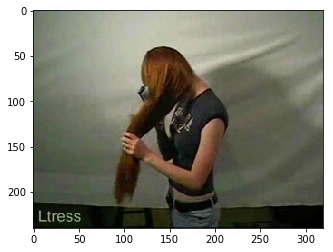

In [7]:
# TODO: visualize feature vectors coming out from extraction_component
from PIL import Image
import numpy as np
from matplotlib.pyplot import imshow
from torch.autograd import Variable

test_img_path = '/home/ubuntu/data/JHMDB/Rename_Images/brush_hair/red_head_brush_hair_u_cm_np1_le_goo_2/00001.png'
test_img = Image.open(test_img_path, 'r')
test_img = np.asarray(test_img)

imshow(test_img)

Loading pickle: /home/ubuntu/cvlab/pytorch/Sub-JHMDB_pose_stream/get_train_test_split/dic_train.pickle ...
images size? torch.Size([1, 3, 256, 256])

results_numpy type? <type 'numpy.ndarray'>
results_numpy.shape (1, 16, 64, 64)

features_numpy type? <type 'numpy.ndarray'>
features_numpy.shape (1, 256, 64, 64)


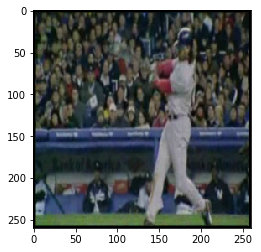

In [43]:
from utils.datasets import jhmdb
from utils import pickle_tools
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms

def my_imshow(img):
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))

jhmdb_dict_path = '/home/ubuntu/cvlab/pytorch/Sub-JHMDB_pose_stream/get_train_test_split/dic_train.pickle'
jhmdb_dict = pickle_tools.load_pickle(jhmdb_dict_path)

jhmdb_rgb_root = '/home/ubuntu/data/JHMDB/Rename_Images'
train_set = jhmdb.JhmdbRgbData(jhmdb_dict, jhmdb_rgb_root, transform=transforms.Compose([
                transforms.Scale([256, 256]),
                transforms.ToTensor()
                ]))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=False, num_workers=2)

# get some training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images_cpu = images.cpu()

# show images
my_imshow(torchvision.utils.make_grid(images))
print('images size?', images.size())
print()

# use the base stacked hourglass model to inference on images
images_cuda = images.cuda()
results = stacked_hourglass_nets(Variable(images_cuda))
results_numpy = results[0].data.cpu().numpy()
print('results_numpy type?', type(results_numpy))
print('results_numpy.shape', results_numpy.shape)
print()

# display pose confidence maps generated by the base stacked hourglass model
"""
for i in range(results_numpy.shape[0]):
    result_numpy = results_numpy[i, :, :, :]
    for c in range(result_numpy.shape[0]):
        channel = result_numpy[c, :, :]
        plt.figure()
        imshow(channel)
"""

# try using pose_feature_net to extract feature
features = pose_feature_net(Variable(images))
#print('features type?', type(features))
#print('features len?', len(features))

features_numpy = features[0].data.cpu().numpy()
print('features_numpy type?', type(features_numpy))
print('features_numpy.shape', features_numpy.shape)
